# EEG Feature Extraction


## Importing all required libraries


In [370]:
import numpy as np
import pandas as pd
import os
import scipy.io
import matplotlib.pyplot as plt
from scipy import signal
import librosa as lr
import librosa.feature as lrf
import sklearn as sk
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler

## Importing data

Open data (in Matlab format)

In [290]:
data_root = 'EEG Data/'

files = os.listdir(data_root)

mat = scipy.io.loadmat(data_root + files[1])

mat['o']['sampFreq'][0][0][0][0]

data = mat['o']['data'][0, 0]
FS = mat['o']['sampFreq'][0][0][0][0]

data


array([[ 32.,   0.,   0., ...,   0.,   0.,   0.],
       [ 33.,   0.,   0., ...,   0.,   0.,   0.],
       [ 34.,   0.,   0., ...,   0.,   0.,   0.],
       ...,
       [123.,   0., 474., ...,   0.,   0.,   0.],
       [124.,   0., 459., ...,   0.,   0.,   0.],
       [125.,   0.,   0., ...,   0.,   0.,   0.]])

In [291]:
def feature_extraction(signal):
    n_mfcc = 5 
    feature_vector = []
    extracted_features = []
    # Timbral Texture Features
    feature_vector.append(lrf.spectral_centroid(signal)) # Spectral Centroid
    feature_vector.append(lrf.spectral_rolloff(signal)) # Rolloff
    feature_vector.append(lr.onset.onset_strength(signal)) # Flux
    feature_vector.append(lr.zero_crossings(signal)) # Zero Crossings
    for mfcc in lrf.mfcc(signal, n_mfcc=n_mfcc): # First 5 MFCCs
        feature_vector.append(mfcc)

    # Pitch Content Features
    n_mel = 10
    n_tonnetz = 6
    feature_vector.append(lr.beat.tempo(signal)) # Tempo
    
    for chroma in lrf.chroma_stft(signal, n_chroma=12): # First 5 MFCCs
        feature_vector.append(chroma)
        
    for mel in lr.power_to_db(lrf.melspectrogram(signal))[:n_mel, :] :
        feature_vector.append(mel)
    
    for tonal in lrf.tonnetz(signal)[:n_tonnetz, :] :
        feature_vector.append(tonal)
        
    for feature in feature_vector:
        extracted_features.append(np.mean(feature))
        extracted_features.append(np.std(feature)) 
        
    # Rhythymic Content Features
    peaks = -np.sort(-lr.onset.onset_strength(signal).flatten())
    A0 = peaks[0]
    A1 = peaks[1]
    RA = A1/A0    
    
    extracted_features.append(np.mean(lrf.tempogram(signal)))
    extracted_features.append(A0)
    extracted_features.append(A1)
    extracted_features.append(RA)
    
    return np.array(extracted_features)

Define channel names following the descripiton of the data set:

4-'EDAF3' 5-'EDF7'
6-'EDF3' 7-'EDFC5'
8-'EDT7' 9-'EDP7'
10-'EDO1' 11-'EDO2'
12-'EDP8' 13-'EDT8'
14-'EDFC6' 15-'EDF4'
16-'EDF8' 17-'EDAF4'

In [292]:
channel_indices = np.array(range(3, 17))
channel_names = ['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4']
channel_map = dict(zip(channel_names, channel_indices))

In [293]:
df = pd.DataFrame.from_dict(data)

Plot a single channel

Text(0, 0.5, 'EEG channel AF3')

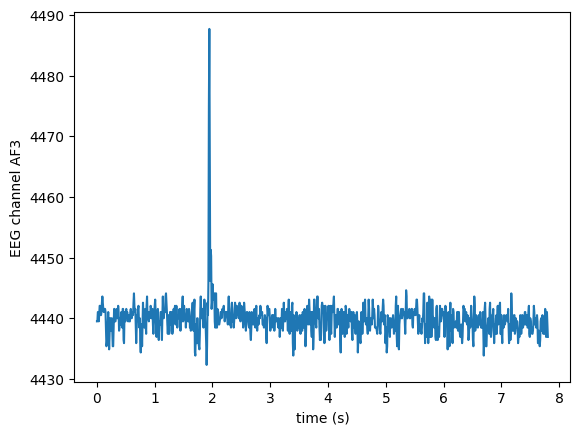

In [294]:
i_ch = 0
time = np.arange(1000) / FS
channel = data[:1000, channel_indices[i_ch]]
plt.plot(time, channel)
plt.xlabel('time (s)')
plt.ylabel(f'EEG channel {channel_names[i_ch]}')

## Extract features

Define states (according to the comments on the Data source).

The states seem to be defined arbitrarily as 10 min adjacent periods.

- 1st 10 minutes of data(t=0 min to t=10 min) is for "focussed" state
- 2nd 10 minutes of data(t=10 min to t=20 min) is for "unfocussed" state
- Remaining data(t=20 min to onwards) is for "Drowsed" state

In [295]:
states = {
 'focused': data[:FS * 10 * 60, :],
  'unfocused': data[FS * 10 * 60:FS * 20 * 60, :],
  'drowsy': data[FS * 30 * 60:, :],
}

Define frequency bands

In [296]:
def get_data(filename):
    mat = scipy.io.loadmat(os.path.join(data_root, filename))
    data = mat['o']['data'][0, 0]
    FS = mat['o']['sampFreq'][0][0][0][0]

    states = {
     'focused': data[:FS * 10 * 60, :],
      'unfocused': data[FS * 10 * 60:FS * 20 * 60, :],
      'drowsy': data[FS * 30 * 60:, :],
    }
    return states

Select subjects

In [297]:
subjects = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 23, 24, 25, 26, 27, 29, 30, 31, 32, 33, 34]

Extract EEG features -> mean powers in delta, alpha, beta, gamma frequency bands

In [298]:
rows_list = []
for subject_idx in subjects:
    states = get_data(f"eeg_record{subject_idx}.mat")
    for ch_name, ch_idx in channel_map.items():
        for state, eeg in states.items():
            powers = feature_extraction(eeg[:, ch_idx])

            rows_list.append(powers)

/var/folders/4f/8lp82fhn6rj3fmpmwgsvbxf00000gn/T/ipykernel_11171/1870593062.py:21: FutureWarning: Pass y=[4440.         4439.48717949 4438.97435897 ... 4437.43589744 4435.8974359
 4441.02564103] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  feature_vector.append(lrf.spectral_centroid(signal)) # Spectral Centroid
/var/folders/4f/8lp82fhn6rj3fmpmwgsvbxf00000gn/T/ipykernel_11171/1870593062.py:22: FutureWarning: Pass y=[4440.         4439.48717949 4438.97435897 ... 4437.43589744 4435.8974359
 4441.02564103] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  feature_vector.append(lrf.spectral_rolloff(signal)) # Rolloff
/var/folders/4f/8lp82fhn6rj3fmpmwgsvbxf00000gn/T/ipykernel_11171/1870593062.py:23: FutureWarning: Pass y=[4440.         4439.48717949 4438.97435897 ... 4437.43589744 4435.8974359
 4441.02564103] as keyword args. From version 0.10 passing these as positional arguments will resu

In [299]:
df = pd.DataFrame.from_dict(rows_list)

## Explore and export data

Save the features to CSV file

In [300]:
#reads the data from the created csv
df.to_csv("eeg_features.csv")

In [663]:
df = pd.read_csv('eeg_features.csv')
df = df.drop('Unnamed: 0', axis=1)

In [664]:
X = df
#19th column is only 0.
X.pop('19')

#labels vector is set up this way to match the sizes.
y = pd.read_csv('labels.csv')
y = y['state']
y = pd.concat([y,y,y,y,y,y,y])
y = y.head(1428)
y=pd.DataFrame(y)

Normalization and Standardization

In [665]:

X = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))*2-1
X = (X - X.mean(axis=0)) / X.std(axis=0)

Test-Training Split

In [666]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=1)
display_labels = ["focused","unfocused","drowsy"]

PCA (0.999 explained variance)

In [667]:
# Encode the genre labels
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, StandardScaler

y = y.reset_index(drop=True)

pca = PCA(n_components = 0.999)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
#X = dataPCA
variance = pd.DataFrame(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_)
print(np.sum(pca.explained_variance_ratio_))


[3.36121945e-01 2.39685096e-01 1.07708519e-01 4.77056944e-02
 3.11587307e-02 2.79471690e-02 2.24011863e-02 1.67013765e-02
 1.61930624e-02 1.37387841e-02 1.26221311e-02 1.23141531e-02
 1.16038624e-02 1.01793544e-02 9.56489575e-03 8.35110495e-03
 7.43194528e-03 7.08312829e-03 5.97452490e-03 5.14187558e-03
 4.48634988e-03 4.14777197e-03 3.75874983e-03 3.73564561e-03
 3.48641773e-03 3.22092977e-03 3.01863349e-03 2.63827445e-03
 2.54833331e-03 2.18651361e-03 2.10407329e-03 1.61078721e-03
 1.50623865e-03 1.46945071e-03 1.31426589e-03 1.21002558e-03
 1.06365168e-03 9.52686968e-04 7.40187660e-04 5.76075545e-04
 5.48839385e-04 4.59472607e-04 4.36774237e-04 3.97500738e-04
 3.13307678e-04 2.63113429e-04 2.32359367e-04 2.10280837e-04
 1.97712605e-04 1.77054547e-04 1.49280399e-04 1.25717668e-04
 1.21832649e-04]
0.9990368491575451


KNN Classifier

In [668]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
print('Accuracy of K-NN classifier on training set: {:.4f}'
     .format(knn.score(X_train, y_train)))
print('Accuracy of K-NN classifier on test set: {:.4f}'
     .format(knn.score(X_test, y_test)))

Accuracy of K-NN classifier on training set: 0.8730
Accuracy of K-NN classifier on test set: 0.7937


/opt/homebrew/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNN Matrix


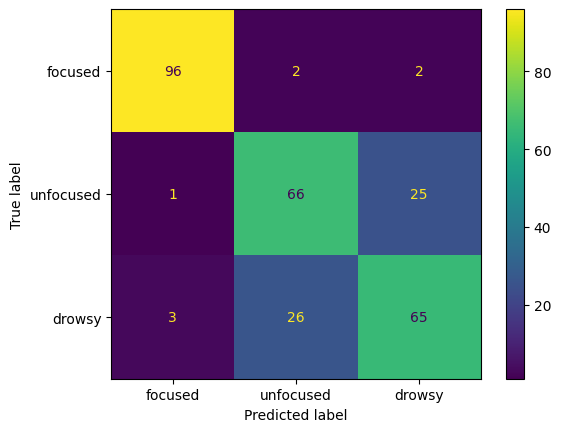

In [669]:
knn_cm = confusion_matrix(y_test, knn.predict(X_test))
knn_disp = ConfusionMatrixDisplay(confusion_matrix=knn_cm,display_labels=display_labels)
print("KNN Matrix")
knn_disp.plot()

Decision Tree Classifier

In [674]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier().fit(X_train, y_train)
print('Accuracy of Decision Tree classifier on training set: {:.4f}'
     .format(dt.score(X_train, y_train)))
print('Accuracy of Decision Tree classifier on test set: {:.4f}'
     .format(dt.score(X_test, y_test)))

Accuracy of Decision Tree classifier on training set: 1.0000
Accuracy of Decision Tree classifier on test set: 0.7028


DT Matrix


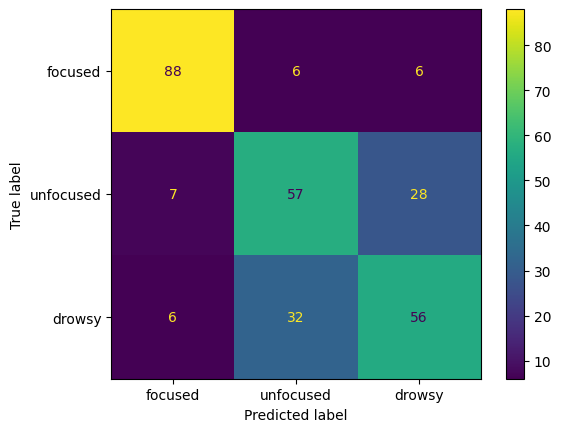

In [675]:
dt_cm = confusion_matrix(y_test, dt.predict(X_test))
dt_disp = ConfusionMatrixDisplay(confusion_matrix=dt_cm,display_labels=display_labels)
print("DT Matrix")
dt_disp.plot()

Random Forest Classifier

In [679]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100).fit(X_train, y_train)
print('Accuracy of RandomForestClassifier classifier on training set: {:.4f}'
     .format(rf.score(X_train, y_train)))
print('Accuracy of RandomForestClassifier classifier on test set: {:.4f}'
     .format(rf.score(X_test, y_test)))

/var/folders/4f/8lp82fhn6rj3fmpmwgsvbxf00000gn/T/ipykernel_11171/1193651153.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf = RandomForestClassifier(n_estimators=100).fit(X_train, y_train)


Accuracy of RandomForestClassifier classifier on training set: 1.0000
Accuracy of RandomForestClassifier classifier on test set: 0.7797


DT Matrix


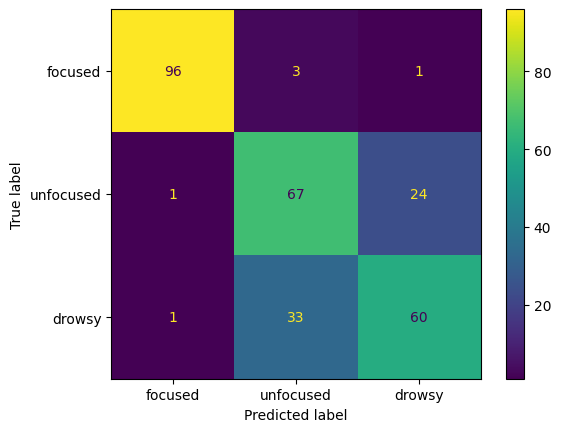

In [687]:
rf_cm = confusion_matrix(y_test, rf.predict(X_test))
rf_disp = ConfusionMatrixDisplay(confusion_matrix=rf_cm,display_labels=display_labels)
print("DT Matrix")
rf_disp.plot()

Logistic Regression Classifier

In [692]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(max_iter=5000)
logreg.fit(X_train, y_train)
print('Accuracy of Logistic regression classifier on training set: {:.4f}'
     .format(logreg.score(X_train, y_train)))
print('Accuracy of Logistic regression classifier on test set: {:.4f}'
     .format(logreg.score(X_test, y_test)))

Accuracy of Logistic regression classifier on training set: 0.8319
Accuracy of Logistic regression classifier on test set: 0.7867


/opt/homebrew/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


lr Matrix


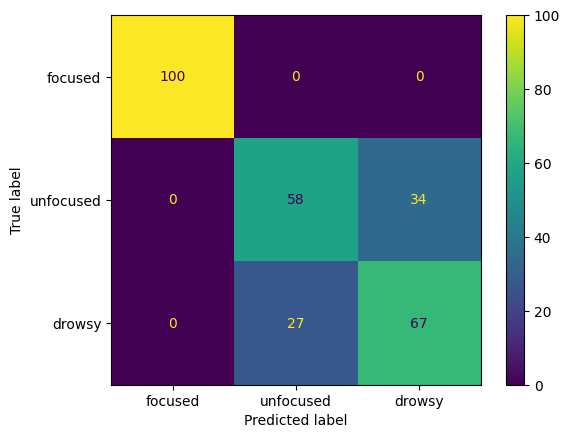

In [693]:
logreg_cm = confusion_matrix(y_test, logreg.predict(X_test))
logreg_disp = ConfusionMatrixDisplay(confusion_matrix=logreg_cm,display_labels=display_labels)
print("lr Matrix")
logreg_disp.plot()

SVM Classifier

In [705]:
from sklearn.svm import SVC
svm = SVC(C=1.0, kernel='linear', degree=10, gamma='scale', coef0=0.0, shrinking=True, probability=False, tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=-1, decision_function_shape='ovr', break_ties=False, random_state=1)
svm.fit(X_train, y_train)
print('Accuracy of SVM classifier on training set: {:.4f}'
     .format(svm.score(X_train, y_train)))
print('Accuracy of SVM classifier on test set: {:.4f}'
     .format(svm.score(X_test, y_test)))


Accuracy of SVM classifier on training set: 0.8468
Accuracy of SVM classifier on test set: 0.7832


/opt/homebrew/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVM Matrix


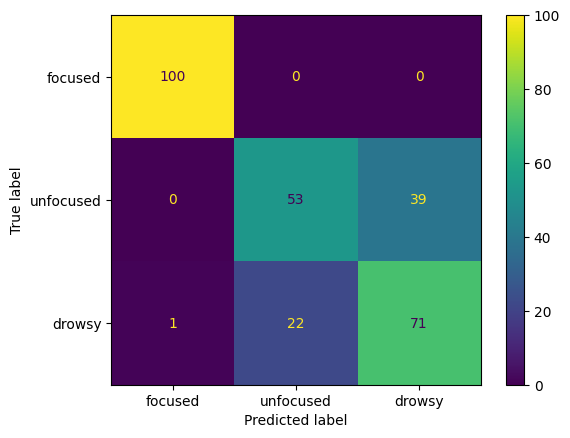

In [706]:
svm_cm = confusion_matrix(y_test, svm.predict(X_test))
display_labels = ["focused","unfocused",'drowsy']
svm_disp = ConfusionMatrixDisplay(confusion_matrix=svm_cm,
                               display_labels=display_labels)
print("SVM Matrix")
svm_disp.plot()

Neural Network Classifier

In [708]:
import sklearn as sk
from sklearn.neural_network import MLPClassifier
NN = MLPClassifier(activation='logistic',solver='adam', alpha=1e-2, learning_rate='adaptive', max_iter=1000000, hidden_layer_sizes=(40), random_state=1)
NN.fit(X_train, y_train)
print('Accuracy of NN classifier on training set: {:.4f}'
     .format(NN.score(X_train, y_train)))
print('Accuracy of NN classifier on test set: {:.4f}'
     .format(NN.score(X_test, y_test)))

/opt/homebrew/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1118: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy of NN classifier on training set: 0.9991
Accuracy of NN classifier on test set: 0.8427


NN Matrix


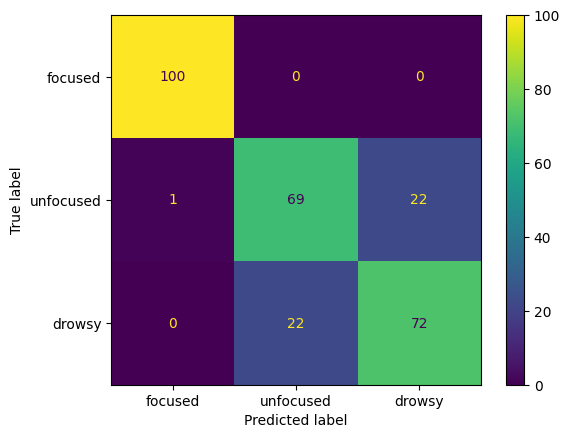

In [709]:
NN_cm = confusion_matrix(y_test, NN.predict(X_test))
NN_disp = ConfusionMatrixDisplay(confusion_matrix=NN_cm,display_labels=display_labels)
print("NN Matrix")
NN_disp.plot()

Gradient Boosting Classifier

In [712]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=10, random_state=1).fit(X_train, y_train)
print('Accuracy of GradientBoostingClassifier on training set: {:.4f}'
     .format(clf.score(X_train, y_train)))
print('Accuracy of GradientBoostingClassifier on test set: {:.4f}'
     .format(clf.score(X_test, y_test)))

/opt/homebrew/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy of GradientBoostingClassifier on training set: 1.0000
Accuracy of GradientBoostingClassifier on test set: 0.7483


clf Matrix


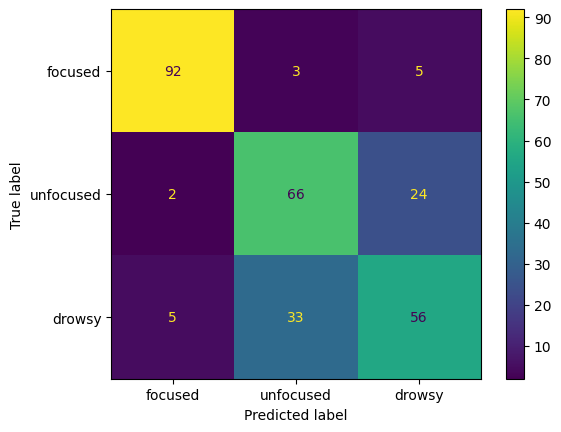

In [713]:
clf_cm = confusion_matrix(y_test, clf.predict(X_test))
clf_disp = ConfusionMatrixDisplay(confusion_matrix=clf_cm,display_labels=display_labels)
print("clf Matrix")
clf_disp.plot()